In [59]:
#importamos las librerías necesarias.
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [60]:
#Función que recibe un string con la altura y devuelve el dato convertido en cm
def feet_to_cm(height_string):
    feet = int(height_string.split("'")[0])
    inches = int(height_string.split("'")[1].split('"')[0])
    cm = 30.48*feet + 2.54*inches
    return cm

In [61]:
#importamos el dataset.
df_nba = pd.read_csv("active_players_2.csv", sep=",")

In [62]:
#Eliminamos todas las columnas que no nos interesan y mnodificamos la columna Position para  darle valores numéricos 
# y unificar los valores similares para tener las 5 posiciones clásicas.
df_nba.drop(columns=['Name','Team','Age','College','Salary','Height_i'], inplace=True)
df_nba['Position'] = df_nba['Position'].replace({"G": np.nan, "F": np.nan})
df_nba.dropna(inplace=True)
df_nba['Position'].unique()



array(['SG', 'PG', 'C', 'SF', 'PF'], dtype=object)

In [63]:
#Pasamos la altura de pies y pulgadas a cm.
df_nba["Height"] = df_nba["Height"].apply(feet_to_cm)


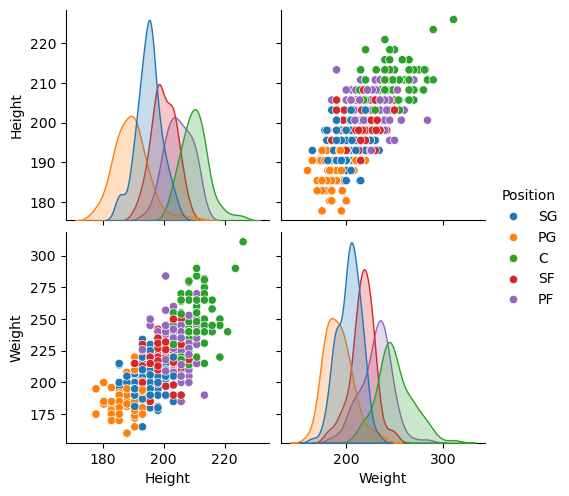

In [64]:
#Para ver la distribución entre las distintas variables usamos pairplot.
sns.pairplot(df_nba, hue='Position')

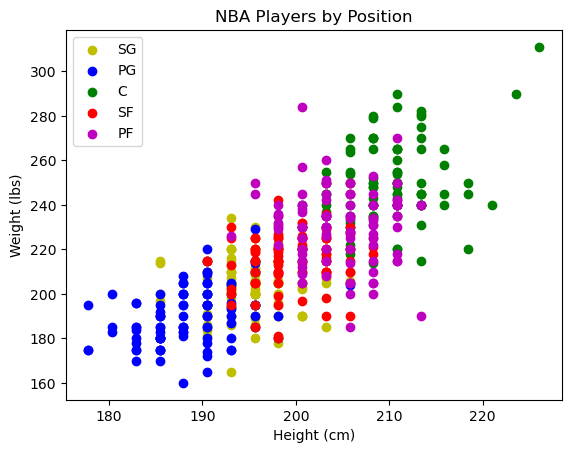

In [65]:
#Pintamos los datos de las dos clases que queremos clasificar. Le damos dos colores distintos. Se puede 
#observar que están bastante diferenciadas.
plt.scatter(df_nba.loc[df_nba['Position']=="SG"]['Height'],df_nba.loc[df_nba['Position']=="SG"]['Weight'],color='y')
plt.scatter(df_nba.loc[df_nba['Position']=="PG"]['Height'],df_nba.loc[df_nba['Position']=="PG"]['Weight'],color='b')
plt.scatter(df_nba.loc[df_nba['Position']=="C"]['Height'],df_nba.loc[df_nba['Position']=="C"]['Weight'],color='g')
plt.scatter(df_nba.loc[df_nba['Position']=="SF"]['Height'],df_nba.loc[df_nba['Position']=="SF"]['Weight'],color='r')
plt.scatter(df_nba.loc[df_nba['Position']=="PF"]['Height'],df_nba.loc[df_nba['Position']=="PF"]['Weight'],color='m')

plt.xlabel('Height (cm)')
plt.ylabel('Weight (lbs)')
plt.title('NBA Players by Position')
plt.legend(df_nba['Position'].unique())
plt.show()


In [66]:
#Creamos el objeto para escalar los datos de entrada y el Support Vector Classifier que vamos a entrenar posteriormente.
df_nba = df_nba.loc[df_nba['Position'].isin(['PG','C'])] 
scaler = StandardScaler()
linear_svc = LinearSVC(C=50,loss='hinge')

In [67]:
#Generamos los datos de entrada para entrenar el modelo.
X = df_nba[['Height','Weight']]
y = df_nba['Position'].to_frame()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [68]:
#Entrenamos. En linear_svc vamos a tener toda la información necesaria para precedir, evaluar el resultado, etc.
linear_svc.fit(X_train,y_train)

/home/ciabd10/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=50, loss='hinge')

In [69]:
#Generamos la lista de valores predichos con el modelo entrenado en base a los datos de entrada de test.
y_pred = linear_svc.predict(X_test)
print(y_pred)

['PG' 'C' 'C' 'C' 'PG' 'C' 'C' 'PG' 'PG' 'PG' 'C' 'C' 'PG' 'C' 'PG' 'C'
 'PG' 'C' 'PG' 'PG' 'C' 'PG' 'C' 'C' 'PG' 'C' 'PG' 'PG' 'C' 'C' 'C' 'C'
 'C' 'C' 'PG' 'PG' 'C' 'PG' 'C' 'PG' 'PG' 'PG' 'PG' 'C' 'C' 'PG' 'C' 'C']


In [70]:
#Usamos el classification report para ver si ha salido bien.
cr = classification_report(y_test, y_pred)
accuracy_score(y_test,y_pred)
print(cr) 



              precision    recall  f1-score   support

           C       0.96      1.00      0.98        25
          PG       1.00      0.96      0.98        23

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



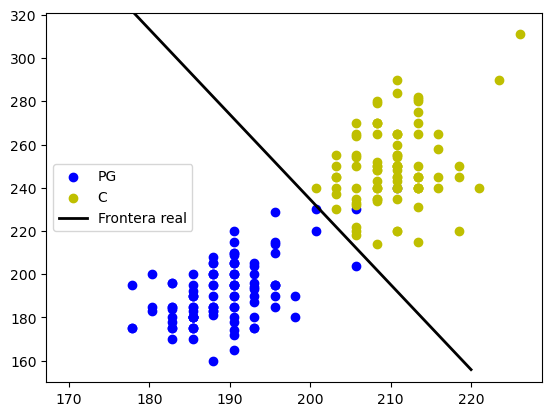

In [72]:
#Ahora vamos a volver a pintar los datos de entrenamiento pero esta vez incluyendo también la recta frontera de la 
#solución.
mean_h, mean_w = scaler.mean_
std_h, std_w = np.sqrt(scaler.var_)

# 2. Parámetros del modelo (tus variables actuales)
a = linear_svc.coef_[0][0]
b = linear_svc.coef_[0][1]
c = linear_svc.intercept_[0]

# 3. Función de la recta ADAPTADA a la escala real
def f_real(x_real):
    # Paso A: Escalamos la X de entrada (Height)
    x_scaled = (x_real - mean_h) / std_h
    # Paso B: Calculamos la Y escalada con la fórmula del SVC
    y_scaled = (-a * x_scaled - c) / b
    # Paso C: Des-escalamos la Y (Weight) para volver a la escala del gráfico
    return y_scaled * std_w + mean_w

# 4. Pintamos con tu estructura original
x_values = np.linspace(170, 220, 100) # Ajustado al rango real de altura

plt.scatter(df_nba[df_nba['Position']=="PG"]['Height'], df_nba[df_nba['Position']=="PG"]['Weight'], color='b', label='PG')
plt.scatter(df_nba[df_nba['Position']=="C"]['Height'], df_nba[df_nba['Position']=="C"]['Weight'], color='y', label='C')

# Usamos la nueva función f_real
plt.plot(x_values, f_real(x_values), color='k', linewidth=2, label='Frontera real')

plt.ylim(df_nba['Weight'].min()-10, df_nba['Weight'].max()+10) # Para que no se vea el hueco

plt.legend()
plt.show()


<div style="border-style:groove;border-width:thin;padding:10px">    
En este ejercicio hemos usado la librería LinearSVC. Vamos a verla en más profundidad:
    <h2>Linear Support Vector Classification.</h2>
    <p>Es similar a la clase, más genérica, SVC con el parámetro kernel='linear'. Sin embargo, implementa otras librerías que la hacen más flexible a la hora de escoger la función de pérdida y debería escalar mejor. Se recomienda su uso para clasificadores lineales basados en SVM.</p>
    <p>Parámetros más importantes:</p>
    <ul>
        <li><b>loss:</b>{‘hinge’, ‘squared_hinge’}, default=’squared_hinge’: Para especificar la función de pérdida. ‘hinge’ es la función de pérdida habitual de SVM, mientras que "squared_hinge" es la función al cuadrado. </li>
        <li><b>C:</b>float, default=1.0: El parámetro de regularización. Siempre debe ser positivo. Cuanto más grande sea menos datos permitimos que se clasifiquen mal. Hay que tener cuidado porque si lo hacemos muy grande probablemente el problema generalizará mal las soluciones.</li>
        <li><b>fit_intercept:</b>bool, default=True: Si no calculamos el intercept estamos dando por hecho que es 0. Si sabemos que va a ser 0 por las características de nuestro problema podemos usar este parámetro para ahorrar tiempo de cómputo.</li>
        <li><b>verbose:</b>int, default=0: Sirve para habilitar los resultados intermedios. Nos da más información del proceso.</li>
        <li><b>random_state:</b>int, RandomState instance or None, default=None: Nos permite que cada vez que se genera un número pseudoaleatorio este sea el mismo. Así podemos tener repetitividad en los resultados.</li>
        <li><b>max_iter:</b>int, default=1000: El máximo número de veces que queremos que trate de entrenar el modelo.</li>
    </ul>      
    <p>Atributos más importantes:</p>
    <ul>
        <li><b>coef_:</b>ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features): Los coeficientes calculados. Nos sirven para ver la recta de decisión.</li>
        <li><b>intercept_:</b>ndarray of shape (1,) if n_classes == 2 else (n_classes,): El término independiente de la recta.</li>
    </ul>
    <p>Más información en:</p>
    <a>https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html</a>
    
</div>